In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Dec  5 12:53:49 2021

@author: Andrey.Bezrukov
"""

import time
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import interpolate
from sklearn.cluster import DBSCAN
import numpy as np

##################################################
####### define  functions 
##################################################

class file_Sorption:
    
    def read_file(self, path, filename):
        #print(path +'/'+ filename)        
        try:
            df = pd.read_excel(path + filename, sheet_name='DVS Data')
            if df.columns[0] == 'DVS-INTRINSIC DATA FILE':
                self.filename = filename
                self.instrument = df.columns[0].split()[0]
                self.sample_mass = df.iloc[4, 7]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[3, 1])
                method = str(df.iloc[1, 1])
                df.columns = df.iloc[22, :]
                df = df.iloc[23:, :]
                df = df.reset_index(drop=True)
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time (min)', 'dm (%) - ref', 'Target RH (%)', 'Actual RH (%)', 'Target Sample Temp', 'Actual Sample Temp']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Actual Sample Temp: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Advantage-Plus-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[39, :]
                df = df.iloc[40:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Mass [mg]', 'Target Partial Pressure (Solvent A) [%]', 'Measured Partial Pressure (Solvent A) [%]', 'Target Preheater Temp. [celsius]', 'Measured Preheater Temp. [celsius]']]
                df.columns = ['time', 'uptake', 'mass', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
            elif df.columns[0] == 'DVS-Vacuum-Data-File':
                self.filename = filename
                self.instrument = df.columns[0][:-10]
                self.sample_mass = df.iloc[27, 1]
                self.fluid = 'water vapor'
                comments  = str(df.iloc[8, 1])
                method = str(df.iloc[3, 1])
                df.columns = df.iloc[40, :]
                df = df.iloc[41:, :30]
                df = df.reset_index(drop=True)
                df = df[[i for i in df.columns if (i == i) & (i != 'Chiller State')]]
                df = df.astype('float')
                # renaming columns to common notation
                df = df[['Time [minutes]', 'dm (%) - ref', 'Target Relative Pressure [%]', 'Actual Relative Pressure [%]', 'Target Preheater Temperature [°C]', 'Actual Preheater Temperature [°C]', 'Mass [mg]']]
                df.columns = ['time', 'uptake', 'RH_target', 'RH_actual', 'temp_target', 'temp_actual', 'mass']
                self.temperature = 'Temp. [celsius]: {0:.2f} +- {1:.2f}'.format(df[df.temp_target==df.temp_target.min()].temp_actual.mean(), df[df.temp_target==df.temp_target.min()].temp_actual.std())
                self.equilibration_interval = '---'
                self.comments = comments
                self.method = method
                self.data = df
                #print(self.data.head())
        except Exception as e:
            print(e)
        #print(self.__dict__.keys())
        # test if import was correct
        if (list(self.__dict__.keys()) == ['filename', 'instrument', 'sample_mass', 'fluid', 'temperature', 'equilibration_interval', 'comments', 'method', 'data'])  :
            print('File {0} read succesfull'.format(filename))
            self.import_success = True
        else:
            self.import_success = False


def Create_WaterSorption_isotherm(Sorption):
    if True:
        Sorption.data['cycle_split'] = Sorption.data['RH_target'].diff().fillna(0)
        split_index_ads = Sorption.data.index[(Sorption.data['cycle_split']>0)].to_list()
        split_index_des = Sorption.data.index[(Sorption.data['cycle_split']<0)].to_list()
        
        index_tuple = [('ads', i) for i in split_index_ads] + [('des', i) for i in split_index_des]
        index_tuple = sorted(index_tuple, key=lambda x: x[1])
        #print(index_tuple)
        isotherm_split = []
        prev = 'ads'
        for i, j in enumerate([i[0] for i in index_tuple]):
            if (j == 'ads')&(prev=='des'):
                isotherm_split.append(index_tuple[i][1])
            prev = j
        print(isotherm_split)
        args = [0]+isotherm_split+[Sorption.data.index.size]
        #args= args[:2]
        print(args)
        
        for start,  end in zip(args, args[1:]):
            print(start,  end)
            split_index_ads = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']>0)].to_list()
            split_index_des = Sorption.data.iloc[start:end].index[(Sorption.data.iloc[start:end]['cycle_split']<0)].to_list()
            
            split_index_des.append(Sorption.data.iloc[start:end].index.to_list()[-1])
            split_index_ads = split_index_ads + [split_index_des[0]]
            
            #print(split_index_ads)
            #print(split_index_des)
            isotherm_RHtarget_ads = []
            isotherm_RHactual_ads = []
            isotherm_adsorption = []
            isotherm_adsorption_time = []
            isotherm_RHtarget_des = []
            isotherm_RHactual_des = []
            isotherm_desorption = []
            isotherm_desorption_time = []
            for i, split in enumerate(split_index_ads[:]):
                isotherm_adsorption.append(Sorption.data[split-10:split].uptake.median())
                if i==0:
                    isotherm_RHtarget_ads.append(Sorption.data[:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[:split_index_ads[i]].RH_actual.median())
                    isotherm_adsorption_time.append(0)
                else:
                    isotherm_RHtarget_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_target.median())
                    isotherm_RHactual_ads.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].RH_actual.median())
                    isotherm_adsorption_time.append(Sorption.data[split_index_ads[i-1]:split_index_ads[i]].time.max() - \
                                                 Sorption.data[split_index_ads[i-1]:split_index_ads[i]].time.min())
            for i, split in enumerate(split_index_des[:]):
                isotherm_desorption.append(Sorption.data[split-10:split].uptake.median())
                if i == 0:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_ads[-2]:split_index_ads[-1]].RH_actual.median())
                    isotherm_desorption_time.append(0)
                else:
                    isotherm_RHtarget_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_target.median())
                    isotherm_RHactual_des.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].RH_actual.median())
                    isotherm_desorption_time.append(Sorption.data[split_index_des[i-1]:split_index_des[i]].time.max() - \
                                                   Sorption.data[split_index_des[i-1]:split_index_des[i]].time.min())
    
    return isotherm_RHtarget_ads, [i for i in isotherm_adsorption], isotherm_RHtarget_des, [i for i in isotherm_desorption],  isotherm_adsorption_time, isotherm_desorption_time


In [2]:
window1 = 50
window2 = 10
text_size = 14

result = pd.DataFrame(columns=['name','isotherm','cycleNr','kinetics'], dtype=object)

datetime_stamp = datetime.now().isoformat(timespec='seconds')

#os.mkdir(datetime_stamp+'/')

import_parameters = pd.read_csv('../input_data.csv', sep=',')
import_parameters.cycleNr = import_parameters.cycleNr.astype('int32')
print(import_parameters)

analysis_time = pd.DataFrame(columns=['name','isotherm_time','kinetics_time', 'isotherm_mass', 'kinetics_mass'], dtype=object)

                                    path_kinetics  \
0   ../../../../data/water_sorption/DVS/kinetics/   
1   ../../../../data/water_sorption/DVS/kinetics/   
2   ../../../../data/water_sorption/DVS/kinetics/   
3   ../../../../data/water_sorption/DVS/kinetics/   
4   ../../../../data/water_sorption/DVS/kinetics/   
5   ../../../../data/water_sorption/DVS/kinetics/   
6   ../../../../data/water_sorption/DVS/kinetics/   
7   ../../../../data/water_sorption/DVS/kinetics/   
8   ../../../../data/water_sorption/DVS/kinetics/   
9   ../../../../data/water_sorption/DVS/kinetics/   
10  ../../../../data/water_sorption/DVS/kinetics/   
11  ../../../../data/water_sorption/DVS/kinetics/   
12  ../../../../data/water_sorption/DVS/kinetics/   
13  ../../../../data/water_sorption/DVS/kinetics/   
14  ../../../../data/water_sorption/DVS/kinetics/   
15  ../../../../data/water_sorption/DVS/kinetics/   
16  ../../../../data/water_sorption/DVS/kinetics/   
17  ../../../../data/water_sorption/DVS/kineti

### plot Figure 3 only equilibrium isotherms

path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Syloid_kinetics_50-100um_27C_12mg-2021-07-15 1...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm          syloid_isotherm_25C-2021-03-19 23-03-21.xls
color                                                            green
name                                                       Syloid AL-1
cycleNr                                                              3
analyze                                                              Y
to_paper                                                           NaN
Name: 0, dtype: object
File syloid_isotherm_25C-2021-03-19 23-03-21.xls read succesfull
[]
[0, 41880]
0 41880
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Zeolite13X_TGApan_kinetics-2022-05-04 21-27-59...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    20191224_Zeoleite

File HP-MCP_isotherm_27C_TGApan-2022-10-06 11-58-55.xls read succesfull
[]
[0, 33428]
0 33428
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics      KollidonSR_kinetics_27C-2022-08-18 11-35-52.xls
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    KollidonSR_isotherm_27C_TGApan-2022-10-06 11-5...
color                                                            green
name                                                          Kollidon
cycleNr                                                              1
analyze                                                              Y
to_paper                                                           NaN
Name: 11, dtype: object
File KollidonSR_isotherm_27C_TGApan-2022-10-06 11-58-55.xls read succesfull
[]
[0, 33428]
0 33428
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    Al-fum_NK-1091_50-100um_kinetics_10mg-2022-04-...
pat

File 20190408_hcp-UIO-66 - Mon 08 Apr 2019 11-55-31.xls read succesfull
[]
[0, 60721]
0 60721
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics    20190923_AAB380-AAB382_UiO-NH2-66_Kinetics - T...
path_isotherm           ../../../../data/water_sorption/DVS/isotherms/
filename_isotherm    20190923_AAB380-AAB382_UiO-NH2-66 - Mon 23 Sep...
color                                                            green
name                                                        UiO-66-NH2
cycleNr                                                              1
analyze                                                              Y
to_paper                                                           NaN
Name: 22, dtype: object
File 20190923_AAB380-AAB382_UiO-NH2-66 - Mon 23 Sep 2019 15-45-59.xls read succesfull
[]
[0, 58207]
0 58207
path_kinetics            ../../../../data/water_sorption/DVS/kinetics/
filename_kinetics       AAB-3-103_kinetics_27C-2022-08-18 21-17-

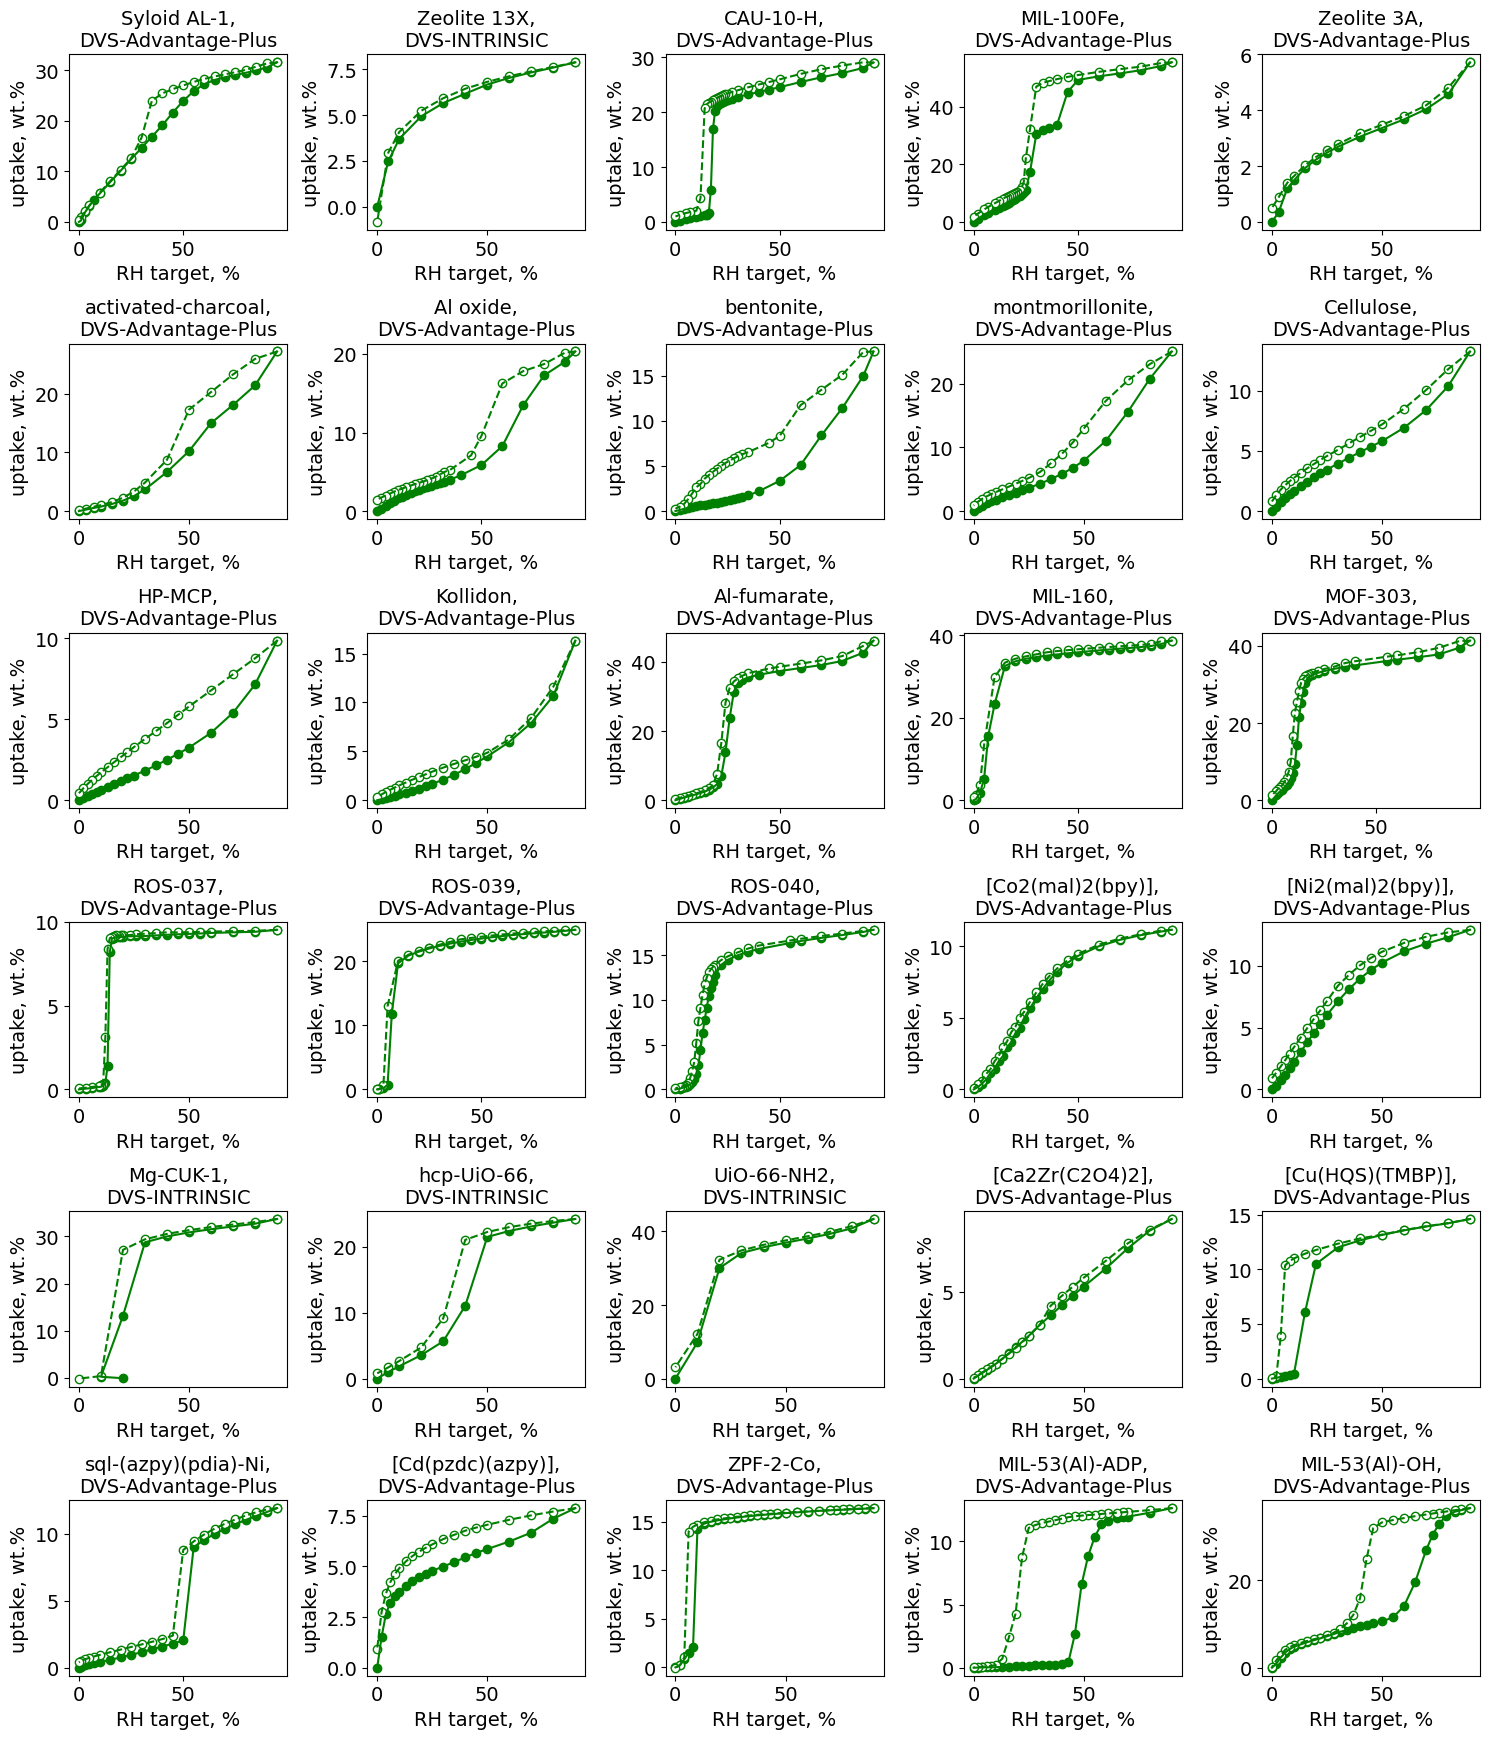

In [3]:
nrow = 6
ncol = 5
fig, ax = plt.subplots(nrow, ncol, figsize=(15, 17.5))

for indx in import_parameters[import_parameters.analyze=='Y'].index:
    print(import_parameters.iloc[indx, :])
        
    ## import isotherm
    Sorption_isotherm = file_Sorption()
    try:
        Sorption_isotherm.read_file(import_parameters.path_isotherm[indx],import_parameters.filename_isotherm[indx])
        if Sorption_isotherm.import_success:
            if Sorption_isotherm.fluid != 'water vapor':
                del Sorption_isotherm
                print('Wrong fluid: ',Sorption_isotherm.fluid)
        else:
            del Sorption_isotherm
            print(import_parameters.filename_isotherm[indx], 'failed')
    except Exception as e:
        print(e)
        print(import_parameters.filename_isotherm[indx], 'failed')
        continue


    # plot experimental isotherm
    try:
        isotherm_RHtarget_ads, isotherm_adsorption, isotherm_RHtarget_des, isotherm_desorption, \
        isotherm_adsorption_time, isotherm_desorption_time = Create_WaterSorption_isotherm(Sorption_isotherm)
    
        exp_isotherm_ads = pd.DataFrame({'RH_ads':isotherm_RHtarget_ads, 
                                 'ads':isotherm_adsorption,
                                'ads_time':isotherm_adsorption_time})
        #print(exp_isotherm_ads)
        exp_isotherm_des = pd.DataFrame({'RH_des':isotherm_RHtarget_des, 
                                 'des':isotherm_desorption,
                                'des_time':isotherm_desorption_time})
        #print(exp_isotherm_des)
        
        ax[indx//ncol, indx%ncol].plot(exp_isotherm_ads.RH_ads, exp_isotherm_ads.ads,
                     c=import_parameters.color[indx],)
        ax[indx//ncol, indx%ncol].plot(exp_isotherm_des.RH_des, exp_isotherm_des.des,
                     c=import_parameters.color[indx], linestyle='dashed')
        ax[indx//ncol, indx%ncol].scatter(exp_isotherm_ads.RH_ads, exp_isotherm_ads.ads,
                        c=import_parameters.color[indx],
                       label='adsorption',)
        ax[indx//ncol, indx%ncol].scatter(exp_isotherm_des.RH_des, exp_isotherm_des.des,
                        facecolors='w', edgecolors=import_parameters.color[indx],
                       label='desorption',)
        ax[indx//ncol, indx%ncol].set_ylabel('uptake, wt.%', fontsize=text_size)
        ax[indx//ncol, indx%ncol].set_xlabel('RH target, %', fontsize=text_size)
        ax[indx//ncol, indx%ncol].tick_params(axis='x', labelsize=text_size)
        ax[indx//ncol, indx%ncol].tick_params(axis='y', labelsize=text_size)
        ax[indx//ncol, indx%ncol].set_title('{0},\n{1}'.format(import_parameters.name[indx],
                                                              Sorption_isotherm.instrument), fontsize=text_size)
        #ax[indx//5, indx%5].set_ylim(limy)
        #ax[indx//5, indx%5].legend()
        #ax[1, 2].set_xlim([(-joined_first_derivative_dwdt['dwdt_scaled']).min(), (-joined_first_derivative_dwdt['dwdt_scaled']).max()])
        #ax[1, 2].set_ylim(limy)

    except Exception as e: 
        print(e)
        pass
        
    
fig.tight_layout()
plt.savefig('Figure_equilibrium-based_isotherms_summary.png', dpi=600)
plt.show()